# Exercise 3

Some default settings.

In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14
from sklearn.utils import check_random_state

## Question 1 

Build $sin(x^2)$ function using backprop framework.

In [24]:
class Square:
    def forward(self, x):
        self.x = x
        return x * x
    
    def backward(self, dLdz):
        dzdx = 2 * self.x
        dLdx = dLdz * dzdx
        return dLdx
    
class Sine:
    def forward(self, x):
        self.x = x
        return np.sin(x)
    
    def backward(self, dLdz):
        dzdx = np.cos( self.x )
        dLdx = dLdz * dzdx
        return dLdx
    
class SineSquare:
    def forward(self, x):
        self.q = Square()
        self.f = Sine()
        
        self.q_out = self.q.forward(x)
        self.f_out = self.f.forward(self.q_out)
            
        return self.f_out
        
    def backward(self, dfdz):
        self.grad_f = self.f.backward(dfdz)
        self.grad_q = self.q.backward(self.grad_f)
        
        return self.grad_q

In [25]:
f = SineSquare()
print('f(x) = ', f.forward(0.3))
print('df/dx = ', f.backward(1.0)) #f = z = sin(x^2), df/dz = 1.0

f(x) =  0.089878549198
df/dx =  0.597571639807


In [26]:
print('f(x) = ', math.sin(0.3*0.3))
print('df/dx = ', 2*0.3*math.cos(0.3*0.3) )

f(x) =  0.08987854919801104
df/dx =  0.5975716398071965


Now plot function and its derivative.

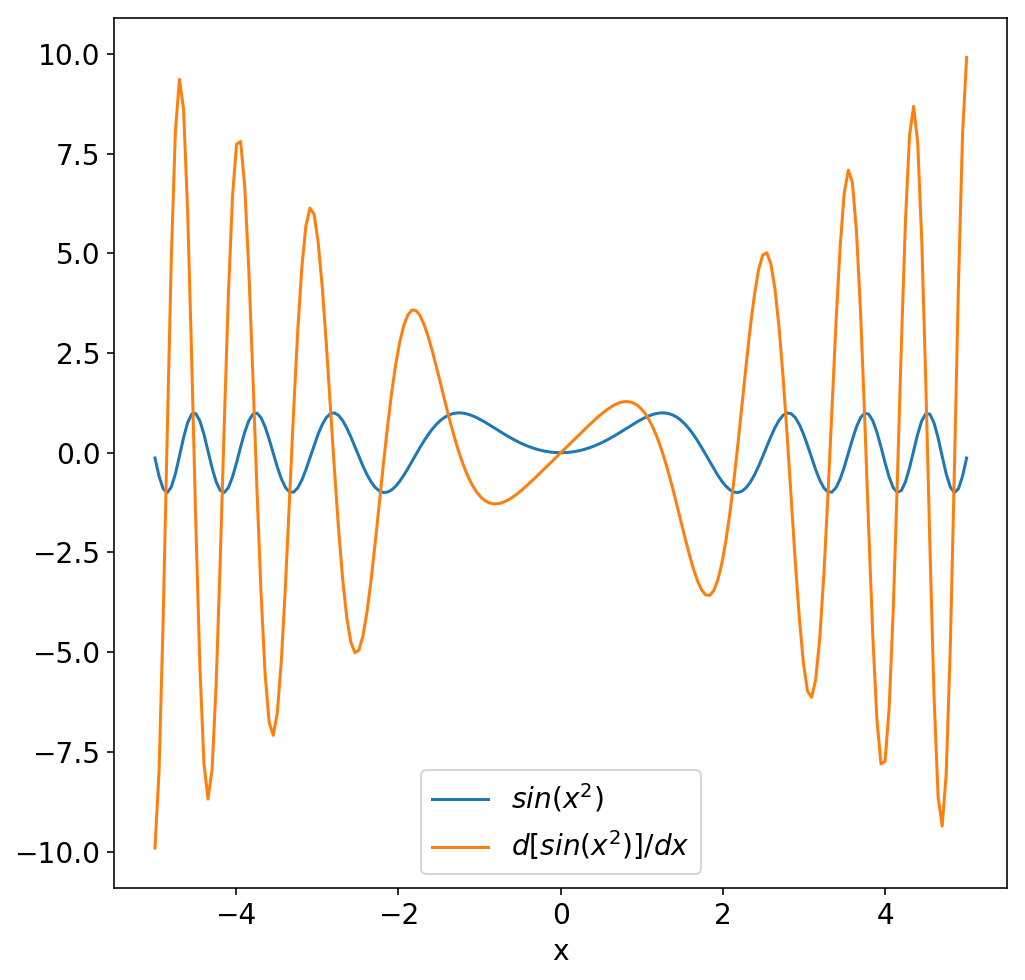

In [34]:
x = np.linspace(-5, 5, 200)

def fun(x):
    f = SineSquare()
    return f.forward(x)

def gradfun(x):
    f = SineSquare()
    val = f.forward(x)
    return f.backward(1.0)

plt.plot(x, fun(x), label='$sin(x^2)$')
plt.plot(x, gradfun(x), label='$d[sin(x^2)]/dx$')
plt.xlabel("x")
plt.legend(loc='best');

## Question 2 

Create circle dataset.

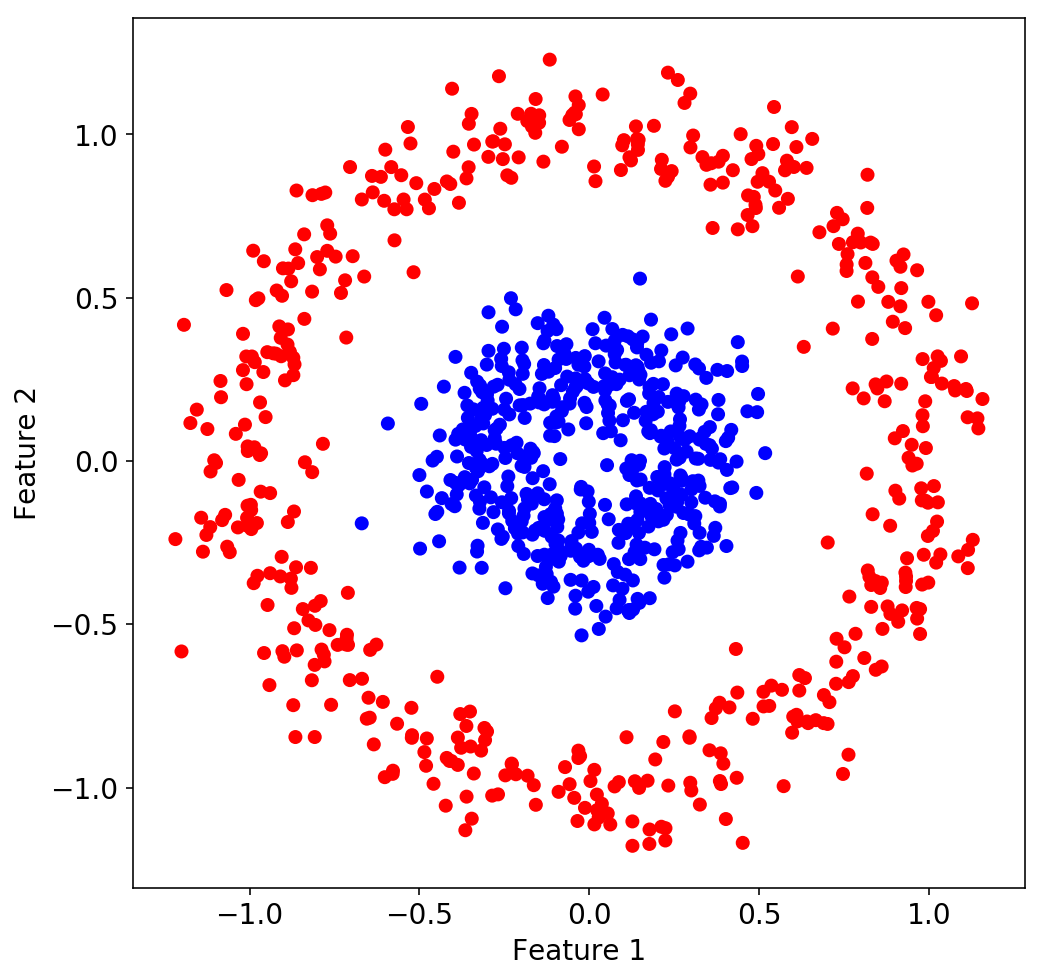

In [152]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, factor=.3, noise=.1)
labels = ['b', 'r']
y = np.take(labels, (y < 0.5))

plt.scatter(X[:,0], X[:,1], c=y)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2");

Classify data using a Neural Network.

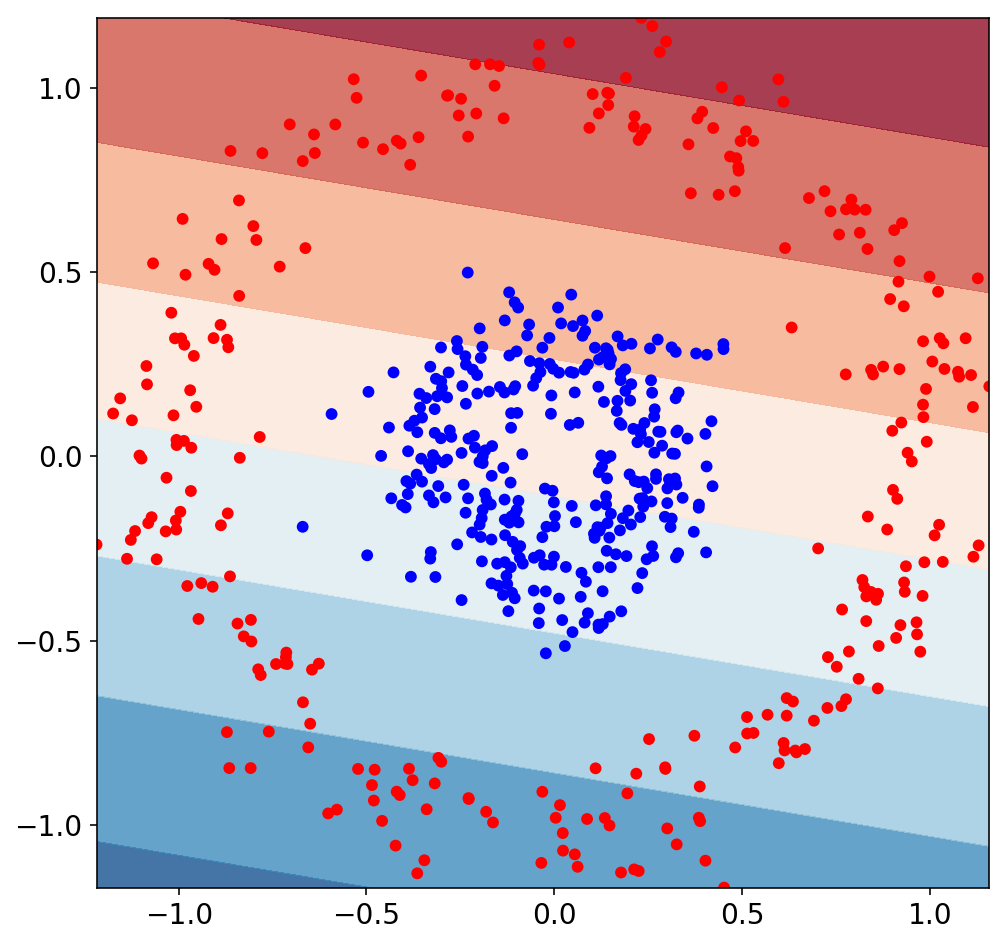

In [153]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from utils import plot_surface

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)

#No hidden layer
clf = MLPClassifier(hidden_layer_sizes=(), 
                    #early_stopping=True,
                    #validation_fraction=0.2,
                    max_iter=5000,
                    random_state=42,
                    activation='relu')

clf.fit(X_train, y_train)
plot_surface(clf, X_train, y_train)

If no hidden layer are used, a linear combination of features is produced as output. This is not enough if data is not linearly separable. Since our data are separable by circles (i.e. second degree polynomial), at least one hidden layer is required.

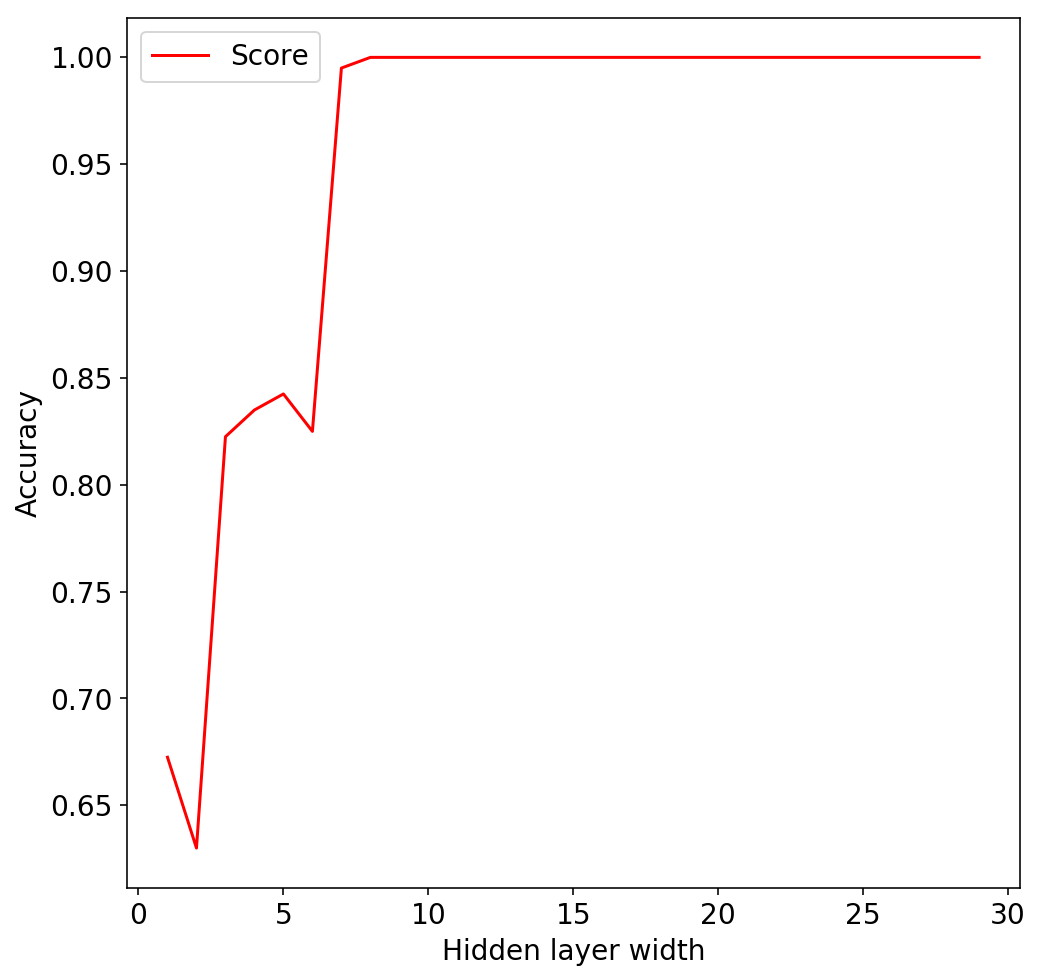

In [112]:
#Optimize layer width for a 1-hidden layer MLP
from sklearn.model_selection import cross_val_score

layer_size = np.arange(1, 30, 1)

scores = []
for lsize in layer_size:
        clf = MLPClassifier(hidden_layer_sizes=(lsize,), 
                    #early_stopping=True,
                    #validation_fraction=0.3,
                    #solver='lbfgs',
                    max_iter=5000,
                    random_state=42,
                    activation='relu')
        clf.fit(X_train,y_train)
        #scores.append(np.average(cross_val_score(clf, X_train, y_train, cv=5)))
        scores.append( clf.score(X_test,y_test) )
plt.plot(layer_size, scores, c='r', label='Score')
plt.xlabel('Hidden layer width')
plt.ylabel('Accuracy')
plt.legend(loc='best');

The accuracy is stable if at least $\sim 10$ neurons are used in the hidden layer.

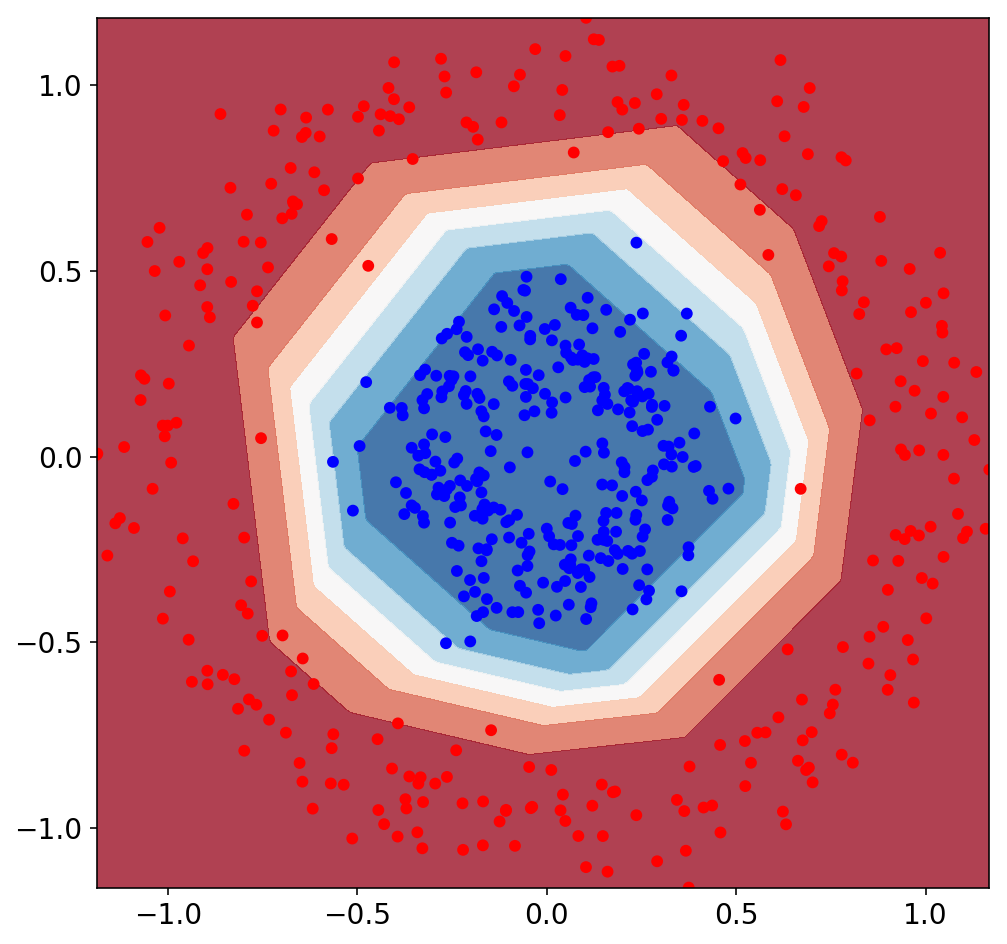

In [113]:
clf = MLPClassifier(hidden_layer_sizes=(10,), 
                    #early_stopping=True,
                    #validation_fraction=0.3,
                    #solver='lbfgs',
                    random_state=42,
                    max_iter=5000,
                    activation='relu')
clf.fit(X_train,y_train)
plot_surface(clf, X_train, y_train)

With polynomial features the problem is solvable without hidden layer, because we transform the problem into a linear one.

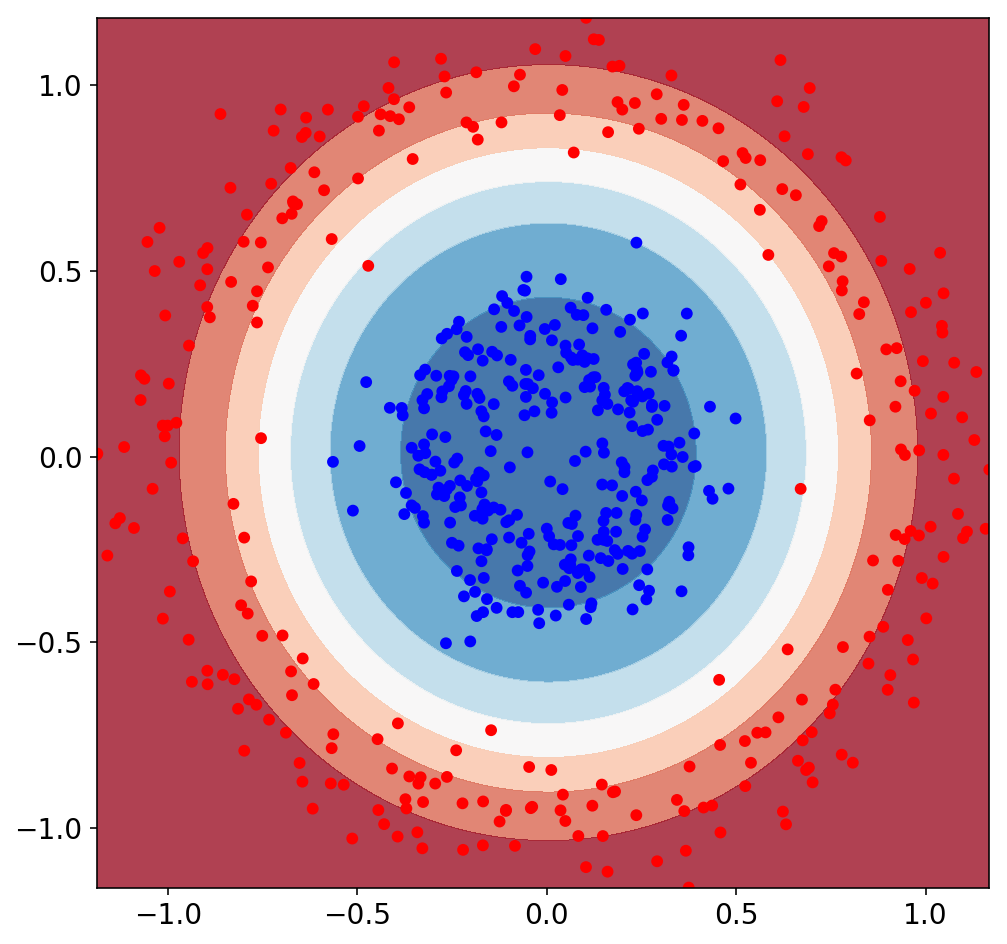

In [99]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

clf = Pipeline([('poly',PolynomialFeatures(degree=2)),
                ('nnet',MLPClassifier(hidden_layer_sizes=(), 
                #early_stopping=True
                #validation_fraction=0.3,
                #solver='lbfgs',
                max_iter=5000,
                random_state=42,
                activation='relu'))])
clf.fit(X_train,y_train)
plot_surface(clf, X_train, y_train);

To understand what the MLP is doing, we could plot the weights. If we have a hidden layer with 10 neurons, the weight matrix is a $2\times 10$ matrix.

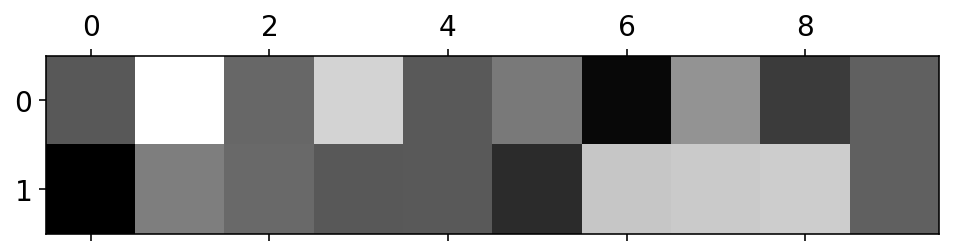

In [147]:
clf = MLPClassifier(hidden_layer_sizes=(10,), 
                    #early_stopping=True,
                    #validation_fraction=0.3,
                    #solver='lbfgs',
                    random_state=42,
                    max_iter=5000,
                    activation='relu')
clf.fit(X_train,y_train)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(np.array(clf.coefs_[0]), cmap=plt.cm.gray);

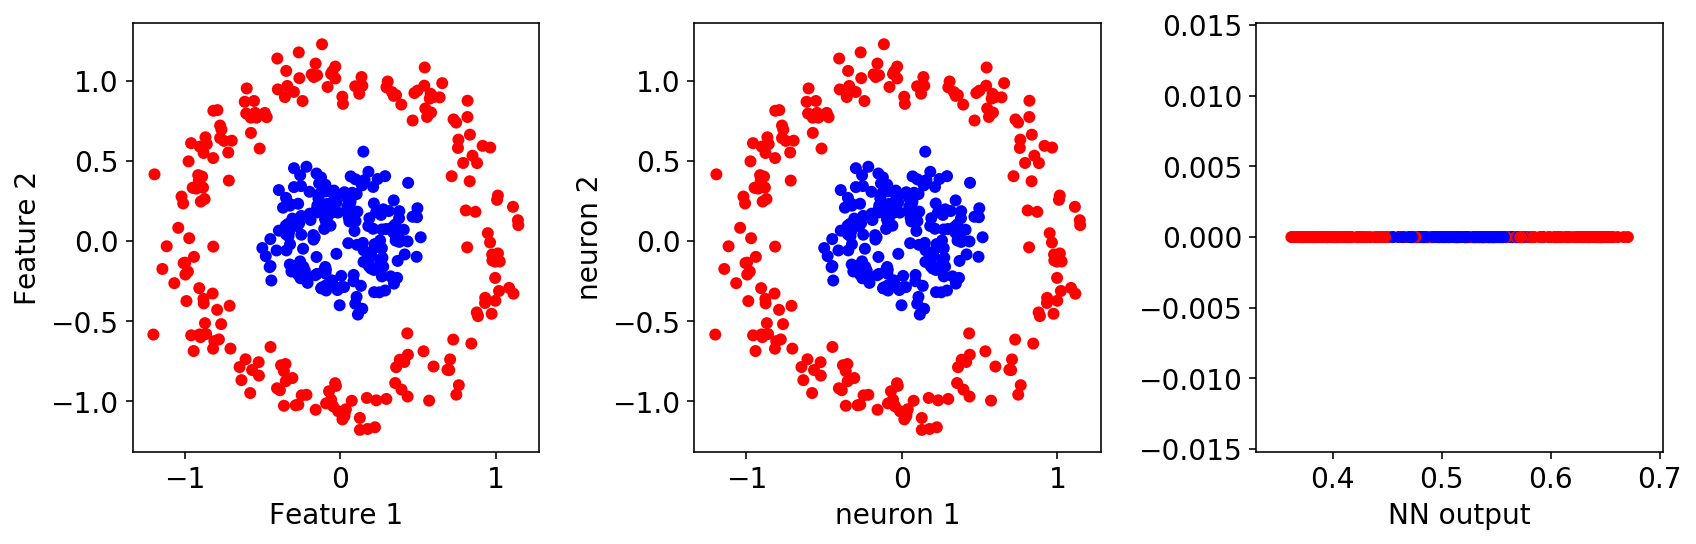

In [176]:
def compute_activations(mlp):
    # re-implement the forward pass logic from within the MLP class
    # so we can access the intermediate activations
    hidden_layer_sizes = mlp.hidden_layer_sizes
    hidden_layer_sizes = list(hidden_layer_sizes)
    layer_units = [X_test.shape[1]] + hidden_layer_sizes + [mlp.n_outputs_]

    activations = [X_test]
    for i in range(mlp.n_layers_ - 1):
        activations.append(np.empty((X_test.shape[0],
                                     layer_units[i + 1])))
    # forward pass
    mlp._forward_pass(activations)
    return activations

def plot_activations(activations):
    hidden_layer = activations[-2]
    y_pred = activations[-1]

    fig, ax = plt.subplots(1, 3, figsize=(12,4))

    # input
    ax[0].scatter(X_test[:,0], X_test[:,1], c=y_test, lw=0.)
    ax[0].set_xlabel('Feature 1')
    ax[0].set_ylabel('Feature 2')

    # hidden layer (two neurons taken at random)
    ax[1].scatter(hidden_layer[:,0], hidden_layer[:,1], c=y_test, lw=0)
    ax[1].set_xlabel('Neuron 1')
    ax[1].set_ylabel('Neuron 2') 
    
    # output layer
    dummy = [0]*len(y_pred)
    ax[2].scatter(y_pred, dummy, c=y_test, lw=0)
    ax[2].set_xlabel('NN output')

    plt.tight_layout();
    plt.show()

activations = compute_activations(clf)
plot_activations( activations )

The code above is somehow broken...

Let's compare Relu and tanh activation functions.

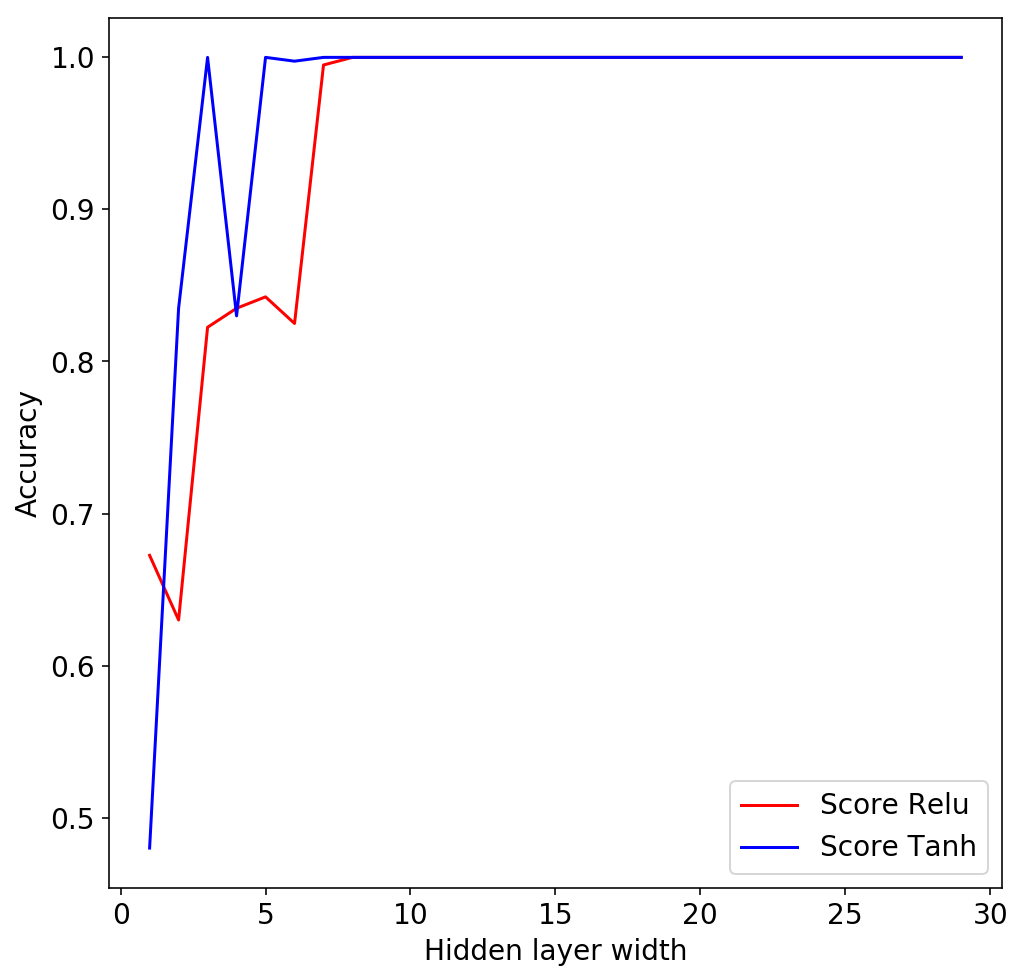

In [115]:
scores_relu = []
scores_tanh = []
for lsize in layer_size:
        clf_relu = MLPClassifier(hidden_layer_sizes=(lsize,),
                    activation='relu',
                    max_iter=5000,
                    random_state=42)
        clf_relu.fit(X_train,y_train)
        scores_relu.append( clf_relu.score(X_test,y_test) )
        clf_tanh = MLPClassifier(hidden_layer_sizes=(lsize,),
                    activation='tanh',
                    max_iter=5000,
                    random_state=42)
        clf_tanh.fit(X_train,y_train)
        scores_tanh.append( clf_tanh.score(X_test,y_test) )
plt.plot(layer_size, scores_relu, c='r', label='Score Relu')
plt.plot(layer_size, scores_tanh, c='b', label='Score Tanh')
plt.xlabel('Hidden layer width')
plt.ylabel('Accuracy')
plt.legend(loc='best');

There is no substantial difference between the two activation functions.

## Question 2.5 

Create and plot spiral dataset

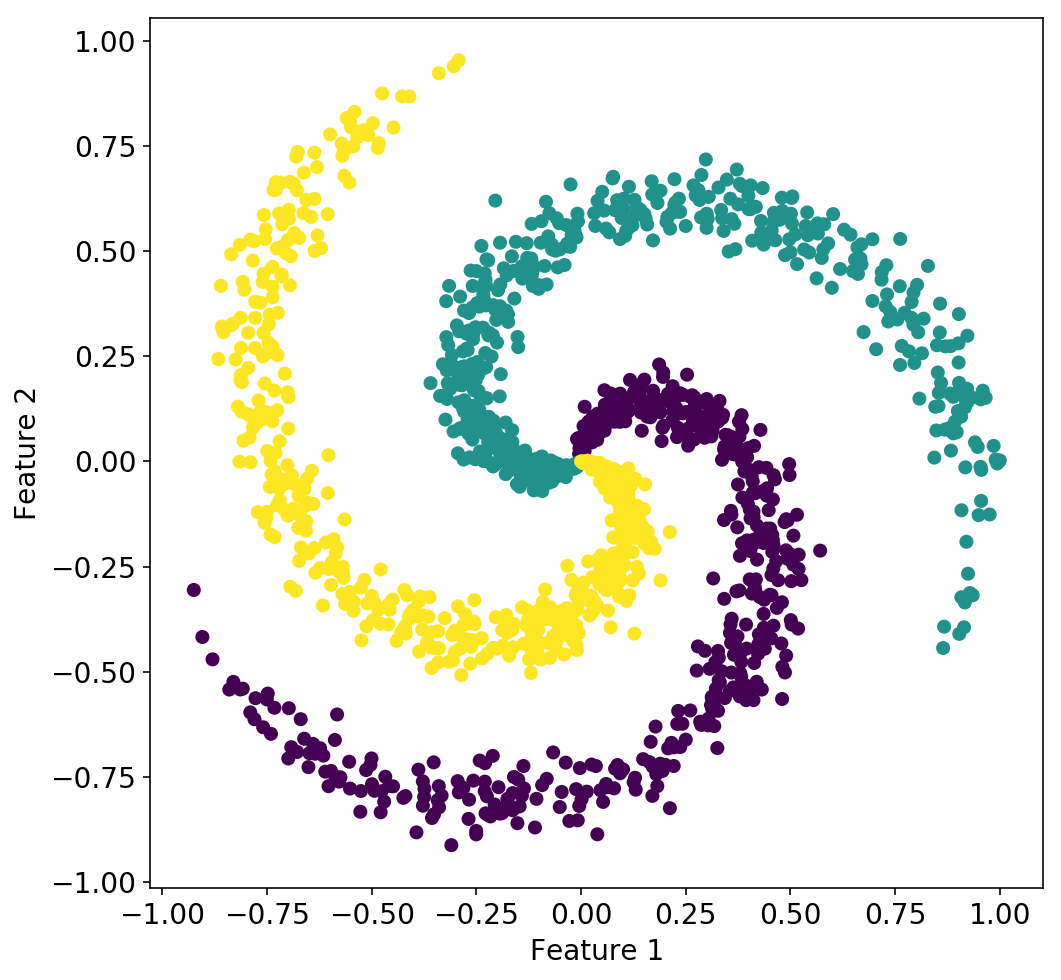

In [177]:
def make_spiral():
    N = 500 # number of points per class
    K = 3 # number of classes
    X = np.zeros((N*K, 2)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels
    for j in range(K):
        ix = range(N*j, N*(j+1))
        r = np.linspace(0.0, 1, N) # radius
        t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j

    return X, y

X, y = make_spiral()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6, random_state=42)
plt.scatter(X[:,0], X[:,1],c=y)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2");

In [178]:
clf = MLPClassifier(hidden_layer_sizes=(50,), 
                    #early_stopping=True,
                    #validation_fraction=0.2,
                    max_iter=5000,
                    random_state=42,
                    activation='relu')

clf.fit(X_train, y_train)
print(clf.predict([[0.5,-0.5]]))
print(clf.predict([[0.5,0.75]]))
print(clf.predict([[-0.75,0.75]]))

[0]
[1]
[2]


Also in this case at least one hidden layer is required since the raw features are not separable linearly.

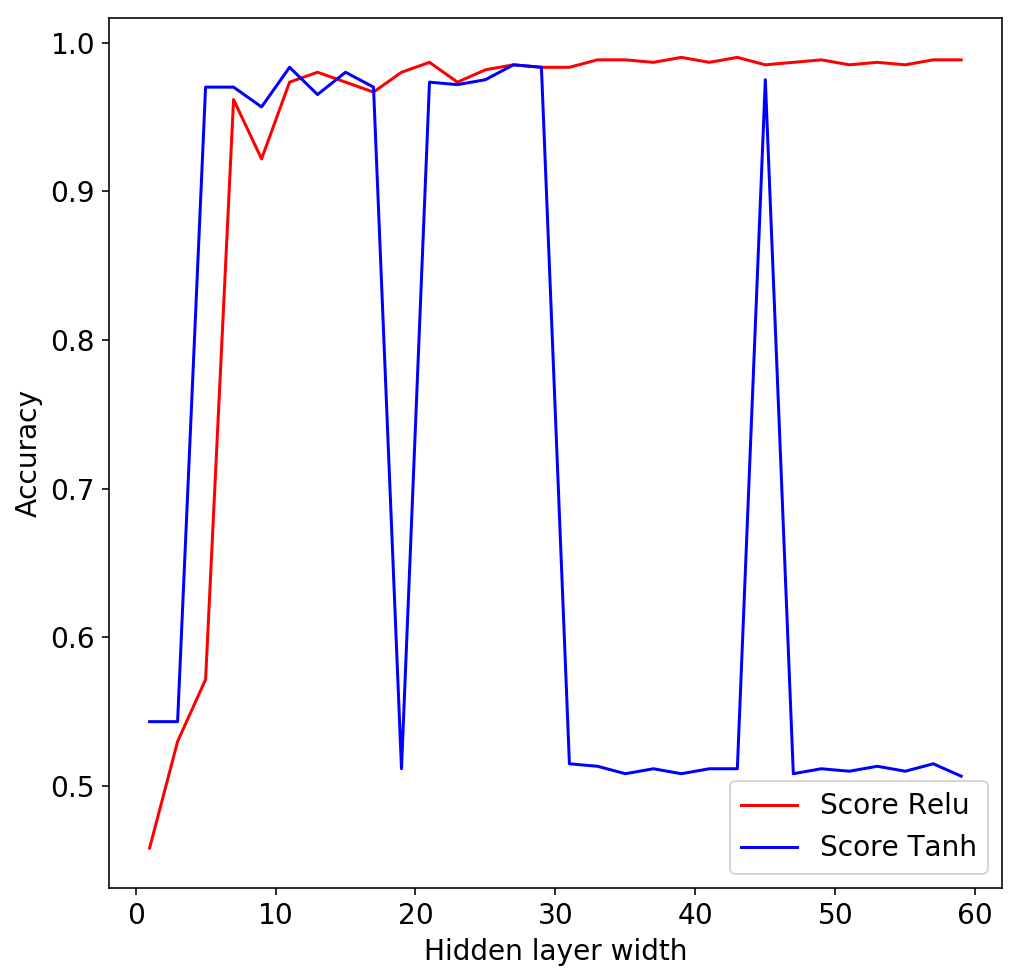

In [180]:
scores_relu = []
scores_tanh = []
layer_size = np.arange(1, 60, 2)
for lsize in layer_size:
        clf_relu = MLPClassifier(hidden_layer_sizes=(lsize,),
                    activation='relu',
                    max_iter=4000,
                    random_state=42)
        clf_relu.fit(X_train,y_train)
        scores_relu.append( clf_relu.score(X_test,y_test) )
        clf_tanh = MLPClassifier(hidden_layer_sizes=(lsize,),
                    activation='tanh',
                    max_iter=4000,
                    random_state=42)
        clf_tanh.fit(X_train,y_train)
        scores_tanh.append( clf_tanh.score(X_test,y_test) )
plt.plot(layer_size, scores_relu, c='r', label='Score Relu')
plt.plot(layer_size, scores_tanh, c='b', label='Score Tanh')
plt.xlabel('Hidden layer width')
plt.ylabel('Accuracy')
plt.legend(loc='best');

The Relu activation function requires at least 20 neurons to converge properly. The tanh function seems unstable.

## Question 3 

In [5]:
# loading the MNIST (or digits) dataset in keras
from keras.datasets import mnist

# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# the first time you run this you need to have internet so it can download the data

Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/Users/Vincenzo/anaconda/lib/python3.5/site-packages/tensorflow/python/__init__.py", line 49, in <module>
    from tensorflow.python import pywrap_tensorflow
  File "/Users/Vincenzo/anaconda/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow.py", line 28, in <module>
    _pywrap_tensorflow = swig_import_helper()
  File "/Users/Vincenzo/anaconda/lib/python3.5/site-packages/tensorflow/python/pywrap_tensorflow.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow', fp, pathname, description)
  File "/Users/Vincenzo/anaconda/lib/python3.5/imp.py", line 242, in load_module
    return load_dynamic(name, filename, file)
  File "/Users/Vincenzo/anaconda/lib/python3.5/imp.py", line 342, in load_dynamic
    return _load(spec)
ImportError: dlopen(/Users/Vincenzo/anaconda/lib/python3.5/site-packages/tensorflow/python/_pywrap_tensorflow.so, 10): Symbol not found: ___sincos_stret
  Referenced from: /Users/Vincenzo/anaconda/lib/python3.5/site-packages/tensorflow/python/_pywrap_tensorflow.so
  Expected in: /usr/lib/libSystem.B.dylib
 in /Users/Vincenzo/anaconda/lib/python3.5/site-packages/tensorflow/python/_pywrap_tensorflow.so


Error importing tensorflow.  Unless you are using bazel,
you should not try to import tensorflow from its source directory;
please exit the tensorflow source tree, and relaunch your python interpreter
from there.